In [ ]:
# Required imports
import os
import h5py
import zipfile
import numpy as np

In [ ]:
import os
import h5py
import numpy as np

# Function to process a single H5 file
def process_h5_file(h5_file_path):
    with h5py.File(h5_file_path, 'r') as h5_file:
        try:
            # Extract relevant features
            FZ = h5_file['derivative_data']['block0_values'][:, 0]
            VitesseMoteur = h5_file['test_conditions']['block0_values'][:, 0]
            TC_BE_S = h5_file['derivative_data']['block0_values'][:, 4]
            TC_BE_M = h5_file['derivative_data']['block0_values'][:, 5]
            TC_BI_S = h5_file['derivative_data']['block0_values'][:, 7]
            TC_BI_M = h5_file['derivative_data']['block0_values'][:, 8]
            TC_BI_E = h5_file['derivative_data']['block0_values'][:, 9]
            TC_BE_10 = h5_file['derivative_data']['block0_values'][:, 10]
            DEP_D = h5_file['derivative_data']['block0_values'][:, 12]
            FY_Smoothed = h5_file['derivative_data']['block0_values'][:, 21]
            isSquealing = h5_file['derivative_data']['block0_values'][:, 42]

            # Combine features into a 2D array: (timesteps, features)
            data = np.stack([FZ, VitesseMoteur, TC_BE_S, TC_BE_M, TC_BI_S, TC_BI_M,
                             TC_BI_E, TC_BE_10, DEP_D, FY_Smoothed, isSquealing], axis=-1)
            return data
        except KeyError as e:
            print(f"Missing dataset in {h5_file_path}: {e}")
            return None

# Process all H5 files and stack data into a single array
def process_all_files(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.h5')]
    processed_data = []

    for file in all_files:
        print(f"Processing file: {file}")
        data = process_h5_file(file)
        if data is not None:
            processed_data.append(data)

    return np.vstack(processed_data) if processed_data else None

# Main workflow
folder_path = './IA/'  # Update with your actual path
combined_dataset = process_all_files(folder_path)

if combined_dataset is not None:
    # Save the combined dataset (raw, unnormalized)
    np.save('./combined_dataset_raw.npy', combined_dataset)
    print(f"Combined dataset shape (raw): {combined_dataset.shape}")
else:
    print("No valid data found for processing.")


Processing file: /content/drive/MyDrive/PA_Last shot/IA/essai33_derivativeDataIA.h5
Processing file: /content/drive/MyDrive/PA_Last shot/IA/essai34_derivativeDataIA.h5
Processing file: /content/drive/MyDrive/PA_Last shot/IA/essai35_derivativeDataIA.h5
Processing file: /content/drive/MyDrive/PA_Last shot/IA/essai36_derivativeDataIA.h5
Processing file: /content/drive/MyDrive/PA_Last shot/IA/essai37_derivativeDataIA.h5
Processing file: /content/drive/MyDrive/PA_Last shot/IA/essai38_derivativeDataIA.h5
Processing file: /content/drive/MyDrive/PA_Last shot/IA/essai39_derivativeDataIA.h5
Processing file: /content/drive/MyDrive/PA_Last shot/IA/essai40_derivativeDataIA.h5
Processing file: /content/drive/MyDrive/PA_Last shot/IA/essai41_derivativeDataIA.h5
Processing file: /content/drive/MyDrive/PA_Last shot/IA/essai42_derivativeDataIA.h5
Processing file: /content/drive/MyDrive/PA_Last shot/IA/essai43_derivativeDataIA.h5
Processing file: /content/drive/MyDrive/PA_Last shot/IA/essai44_derivativeDa

In [ ]:
import numpy as np

# Function to remove outliers row-wise using the IQR method
def remove_outliers(data):
    """
    Removes rows where any feature is an outlier based on the IQR method.
    """
    q1 = np.percentile(data, 25, axis=0)
    q3 = np.percentile(data, 75, axis=0)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Keep rows where all feature values are within bounds
    mask = np.all((data >= lower_bound) & (data <= upper_bound), axis=1)
    return data[mask]

# Load the raw combined dataset
raw_dataset_path = './combined_dataset_raw.npy'
combined_dataset_raw = np.load(raw_dataset_path)

print(f"Raw dataset shape before outlier removal: {combined_dataset_raw.shape}")

# Remove outliers
combined_dataset_cleaned = remove_outliers(combined_dataset_raw)

print(f"Dataset shape after outlier removal: {combined_dataset_cleaned.shape}")

# Save the cleaned dataset
cleaned_dataset_path = './combined_dataset_raw_without_outliers.npy'
np.save(cleaned_dataset_path, combined_dataset_cleaned)
print(f"Cleaned dataset saved to: {cleaned_dataset_path}")


Raw dataset shape before outlier removal: (2085525, 11)
Dataset shape after outlier removal: (1789399, 11)
Cleaned dataset saved to: /content/drive/MyDrive/PA_Last shot/combined_dataset_raw_without_outliers.npy


In [ ]:
import numpy as np

# Function to normalize data dynamically based on the dataset
def normalize_data_dynamic(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    return (data - min_vals) / (max_vals - min_vals), min_vals, max_vals

# Load the cleaned dataset without outliers
cleaned_dataset_path = './combined_dataset_raw_without_outliers.npy'
cleaned_dataset = np.load(cleaned_dataset_path)

# Normalize the cleaned dataset
normalized_dataset, min_values, max_values = normalize_data_dynamic(cleaned_dataset)

# Save the normalized dataset
normalized_dataset_path = './combined_dataset_normalized.npy'
np.save(normalized_dataset_path, normalized_dataset)

# Print normalization details
print(f"Normalized dataset shape: {normalized_dataset.shape}")
print(f"Min values per feature: {min_values}")
print(f"Max values per feature: {max_values}")


Normalized dataset shape: (1789399, 11)
Min values per feature: [ -6.80480687 200.          26.15816594  26.19591501  26.04231519
  25.97105252  26.04207923  26.16547993   6.38031226  -7.46204336
  22.50224995]
Max values per feature: [547.62313117 800.         154.78178625 159.47723178 116.77780758
 143.61281957 155.64683178 166.72005775   8.68751897  19.53823065
  96.81937906]


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Load the normalized dataset
normalized_dataset_path = './combined_dataset_normalized.npy'
normalized_dataset = np.load(normalized_dataset_path)

# Train-test split: 70% training, remaining 30% split into validation and test sets
train_data, temp_data = train_test_split(normalized_dataset, test_size=0.3, random_state=42)

# Validation-test split: 15% each
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Save the splits
np.save('.t/train_data.npy', train_data)
np.save('./val_data.npy', val_data)
np.save('./test_data.npy', test_data)

# Check split shapes
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Testing data shape: {test_data.shape}")


Training data shape: (1252579, 11)
Validation data shape: (268410, 11)
Testing data shape: (268410, 11)


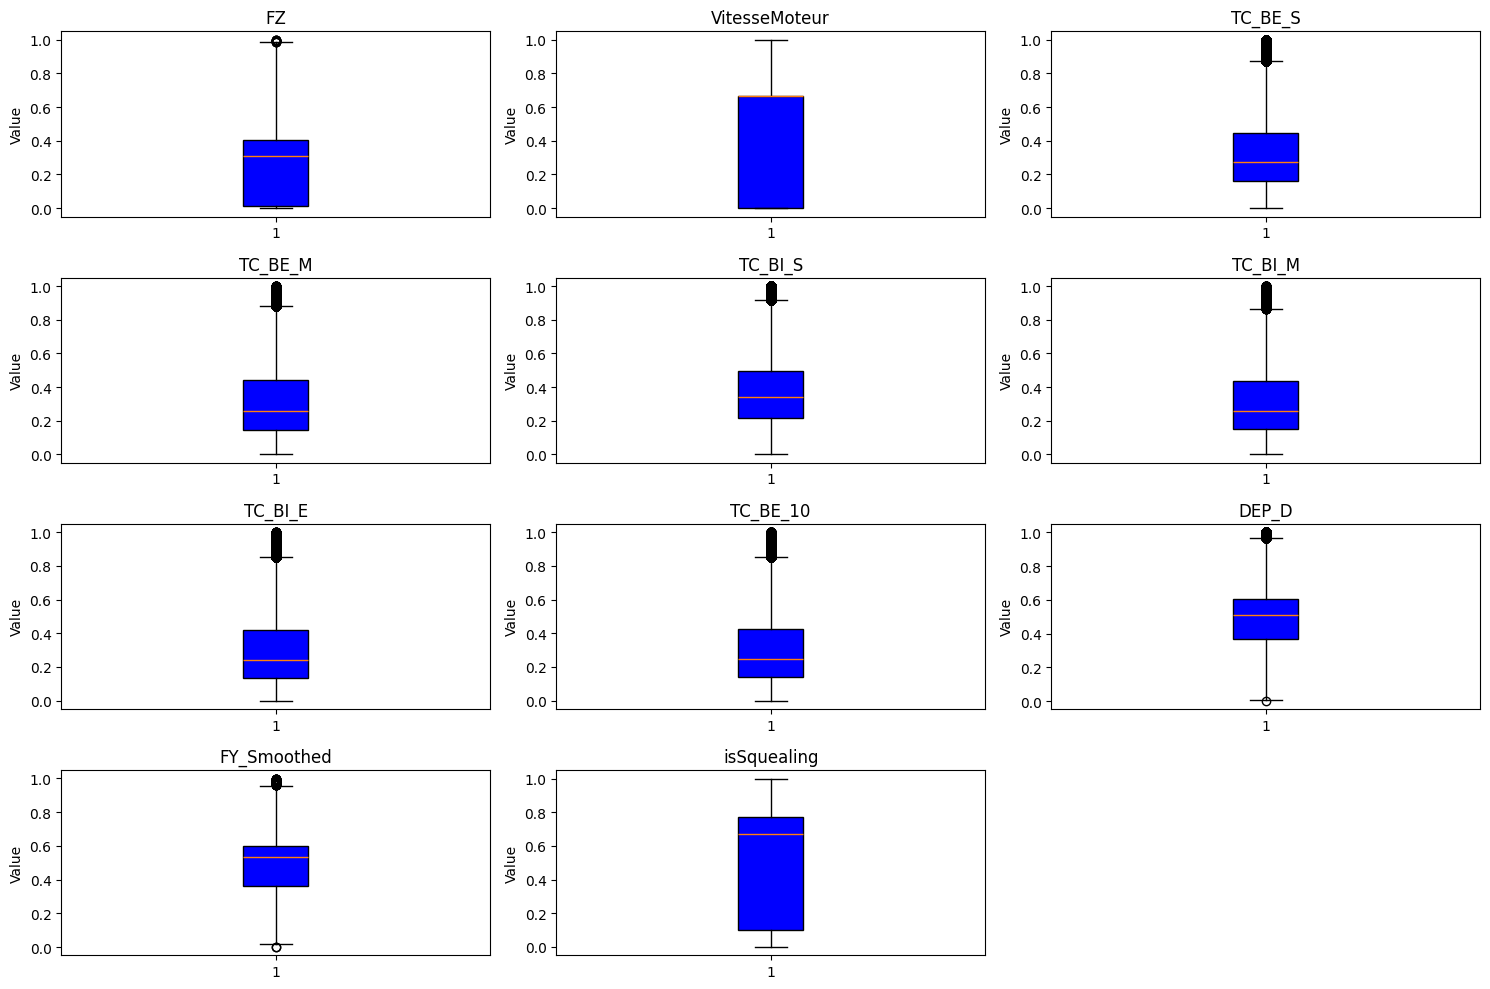

In [ ]:
import matplotlib.pyplot as plt

# Feature names from your dataset
feature_names = ['FZ', 'VitesseMoteur', 'TC_BE_S', 'TC_BE_M', 'TC_BI_S',
                 'TC_BI_M', 'TC_BI_E', 'TC_BE_10', 'DEP_D', 'FY_Smoothed', 'isSquealing']

# Combine all training data
combined_train_data = train_data

# Create boxplots for each feature
plt.figure(figsize=(15, 10))
for i in range(combined_train_data.shape[1]):
    plt.subplot(4, 3, i + 1)
    plt.boxplot(combined_train_data[:, i], patch_artist=True, boxprops=dict(facecolor="blue"))
    plt.title(f'{feature_names[i]}')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()
